In [7]:
from IPython import get_ipython
get_ipython().run_line_magic("reset","-f")

from PyPackageJonas import *

figures_path = "C:/Users/jonas/Git/Analysis-of-Production-flow-systems-with-focus-on-industry/Latex Thesis/figures/"

In [8]:
def akde1d(X, grid = None, gam = None, tol = 10**-5):
    # gam: number of (randomly drawn w.o. repetition) samples from X
    (n,d) = X.shape
    if not gam:
        gam = int(np.ceil( n**(1/3) )) + 20

    
    MAX = X.max(axis=0)
    MIN = X.min(axis=0)
    scaling = MAX - MIN
    MAX = MAX + scaling / 10
    MIN = MIN - scaling / 10
    scaling = MAX - MIN

    X = X - MIN
    X = X / scaling

    
    
    # Initialize algorithm
    del_ = 0.2 / n**(d/(d+4))
    # del_ = 0.05248
    perm = list(range(n)); random.shuffle(perm)

    mu = X[perm[:gam],:]
    w = np.random.uniform(size = (gam))
    w = w/w.sum()
    Sig = del_**2 * np.random.uniform(size = (gam,d))

    ent = -np.inf

    for iter in range(1_500):
        Eold = ent
        # print("entering regEM", iter)
        [w,mu,Sig,del_,ent, log_lh_mean] = regEM(w,mu,Sig,del_,X)
        err = np.abs( ( ent-Eold ) / ent)
        print(f"Iter.      Tol.           Bandwith           log lh.")
        print(f"{iter:5}     {err:10.6}      {del_:10.6}      {log_lh_mean:10.6}")
        if err < tol:             # Super weird. why not use while loop or just loop up to 200 in first place??
            break

    

    if not grid:
        grid = np.linspace(MIN, MAX, 2**12)
    
    mesh = grid - MIN
    mesh = mesh / scaling

    pdf = probfun(mesh, w, mu, Sig) / np.prod(scaling)

    del_ = scaling * del_

    print(f"final band with: {del_}")
    # print(Sig[0,:])
    # Sig : bandwith for each of the observed points

    return [pdf,grid]


def regEM(w,mu,Sig,del_,X):
    eps = sys.float_info.epsilon


    (gam,d) = mu.shape
    (n,d) = X.shape
    log_lh = np.zeros((n,gam))
    log_sig = log_lh.copy()

    for i in range(gam):
        s = Sig[i,:]
        X_centered = X - mu[i,:]
        xRinv = X_centered**2 / s
        xSig = (xRinv / s).sum(axis = 1) + eps



        log_lh[:,i] = -0.5 * xRinv.sum(axis=1) - 0.5*np.log(s).sum() + np.log(w[i]) - d*np.log(2*np.pi)/2 - 0.5*del_**2 * (1/s).sum()
        log_sig[:,i] = log_lh[:,i] + np.log(xSig)

    # print(log_lh.max(axis=1).mean())

    maxll = log_lh.max(axis=1)
    maxlsig = log_sig.max(axis=1)
    p = np.exp(log_lh - maxll[:,None])
    # print(p.shape)
    psig = np.exp(log_sig - maxlsig[:,None])
    density = p.sum(axis=1)
    psigd = psig.sum(axis=1)
    logpdf = np.log(density) + maxll
    logpsigd = np.log(psigd) + maxlsig
    p = p/density[:,None]
    ent = logpdf.sum()
    w = p.sum(axis=0)


    # print((p[:,i] @ X).shape)
    for i in np.where(w > 0)[0]:

        mu[i,:] = p[:,i] @ X / w[i]
        X_centered = X - mu[i,:]
        Sig[i,:] = p[:,i] @ X_centered**2/w[i] + del_**2

    w = w/w.sum()
    curv = np.exp(logpsigd - logpdf).mean()
    del_ = 1/(4 * n * (4*np.pi)**(d/2)* curv)**(1/(d+2))

    return [w, mu, Sig, del_, ent, log_lh.max(axis=1).mean()]


def probfun(x,w,mu,Sig):
    # print(Sig.shape)
    (gam,d) = mu.shape
    out = 0
    for k in range(gam):
        S = Sig[k,:]
        xx = x - mu[k,:]
        xx = xx**2 / S
        out += np.exp(-0.5 * xx.sum(axis=1) + np.log(w[k]) - 0.5*np.log(S).sum() - d*np.log(2*np.pi)/2)
    
    return out

In [9]:
# def eval_new(x_eval, x_i, h):
#     N_kernels = 8
#     p1 = x_eval - x_i[:,None]
#     p2 = x_eval + x_i[:,None]

#     # p1 = (p1 - np.array([2*k for k in range(-N_kernels,N_kernels+1)])[:,None,None])
#     # p2 = (p2 - np.array([2*k for k in range(-N_kernels,N_kernels+1)])[:,None,None])


#     p1 = (p1[:,:,None] - np.array([2*k for k in range(-N_kernels,N_kernels+1)])[None,None,:])
#     p2 = (p2[:,:,None] - np.array([2*k for k in range(-N_kernels,N_kernels+1)])[None,None,:])

#     sum_1 = 1/h * scipy.stats.norm.pdf(p1 / h).sum(axis = 2).mean(axis = 0)
#     sum_2 = 1/h * scipy.stats.norm.pdf(p2 / h).sum(axis = 2).mean(axis = 0)


#     return sum_1 + sum_2

In [10]:
def eval_new(x_eval, x_i, h):
    N_kernels = 8
    p = x_eval + (np.array([[-1],[1]]) * x_i[None,:])[:,:,None]
    k_array = np.array([2*k for k in range(-N_kernels,N_kernels+1)])
    p = p[:,:,:,None] - k_array[None,None,None,:]
    return 1/h * scipy.stats.norm.pdf(p / h).sum(axis = (0,1,3)) / p.shape[1]

In [73]:
u_sample = scipy.stats.uniform.rvs(size=(1_000))
beta_sample = 1- (1-u_sample)**(1/4)
# beta_sample = 1/2 + np.cbrt(((2*u_sample - 1 )/8))
# beta_sample = u_sample

def pdf_fun(x):
    # return 12 * (x-0.5)**2
    res = 4 * (1 - x)**3
    # res = np.ones(x.shape)
    return res



In [74]:
h = kde(beta_sample, MIN = 0, MAX = 1)
print(h[0])

[0.05062922]


In [75]:
# scott h
beta_sample.__len__()**(-1/5) * beta_sample.var()**0.5

0.04172769810237083

In [76]:
kde_Jonas_nn_reg = KernelJones1D_nonnegative(beta_sample, h = h[0])
kde_Jonas_nn_reg_scott = KernelJones1D_nonnegative(beta_sample)

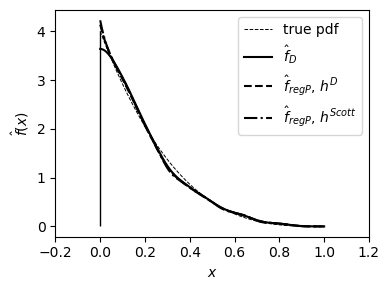

In [77]:
xx = np.linspace(0,1,2000)
# h = 0.05248

fig, ax = plt.subplots(1,1, figsize = (4,3))
# fig, ax = plt.subplots(1,1)
# ax.hist(beta_sample, 25, density = True);
ax.plot(xx, pdf_fun(xx), linestyle="--", color = "black", linewidth = 0.7, label="true pdf")

# ax.plot(akde1d_grid[akde1d_grid.ravel() >= 0],akde1d_pdf[akde1d_grid.ravel() >= 0], label = "akde1d")
# ax.plot(xx, eval_new(xx, beta_sample, 0.0588475), label = "diffusion")
ax.plot(h[2], h[1], label = r"$\hat{f}_D$", linestyle = "-", color = "black")
# plt.plot(xx, 4*(1-xx)**3)
# plt.plot(xx,pdf_fun(xx), label = "truth")

ax.plot(xx, kde_Jonas_nn_reg(xx), label = r"$\hat{f}_{regP}$" + ", " + r"$h^D$", linestyle="--", color = "black")
ax.plot(xx, kde_Jonas_nn_reg_scott(xx), label = r"$\hat{f}_{regP}$" + ", " + r"$h^{Scott}$", linestyle = "-.", color = "black")


ax.set_xlim([-.2,1.2])

ax.vlines(0, 0, 4, colors = "black", linestyles="-", linewidth = 1)

ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\hat{f}\left(x\right)$")
fig.tight_layout()

# plt.savefig(figures_path + "MI estimation/beta dist example - comparison with diffusion and jones.pdf", bbox_inches='tight')
# plt.savefig(figures_path + "MI estimation/beta dist example - comparison with diffusion and jones.png", bbox_inches='tight')

In [17]:
""" kde.py """
import matplotlib.pyplot as plt

def kde(data, n=2**14, MIN=None, MAX=None, plot=False, label = []):
#==============================================================================
# Reliable and extremely fast kernel density estimator for one-dimensional data;
#        Gaussian kernel is assumed and the bandwidth is chosen automatically;
#        Unlike many other implementations, this one is immune to problems
#        caused by multimodal densities with widely separated modes (see example). The
#        estimation does not deteriorate for multimodal densities, because we never assume
#        a parametric model for the data.
# INPUTS:
#     data    - a vector of data from which the density estimate is constructed;
#          n  - the number of mesh points used in the uniform discretization of the
#               interval [MIN, MAX]; n has to be a power of two; if n is not a power of two, then
#               n is rounded up to the next power of two, i.e., n is set to n=2^ceil(log2(n));
#               the default value of n is n=2^12;
#   MIN, MAX  - defines the interval [MIN,MAX] on which the density estimate is constructed;
#               the default values of MIN and MAX are:
#               MIN=min(data)-Range/10 and MAX=max(data)+Range/10, where Range=max(data)-min(data);
#    plot     -  (True/False) whether or not to produce a plot 
#    label    -  (string) label to apply to kde plot 
    
# OUTPUTS:
#   bandwidth - the optimal bandwidth (Gaussian kernel assumed);
#     density - column vector of length 'n' with the values of the density
#               estimate at the grid points;
#     xmesh   - the grid over which the density estimate is computed;
#             - If no output is requested, then the code automatically plots a graph of
#               the density estimate.
#        cdf  - column vector of length 'n' with the values of the cdf
#  Reference: 
# Kernel density estimation via diffusion
# Z. I. Botev, J. F. Grotowski, and D. P. Kroese (2010)
# Annals of Statistics, Volume 38, Number 5, pages 2916-2957. 

#
#  Example:
#              kde(data,2**14,min(data)-5,max(data)+5);
#
#  Notes:   If you have a more reliable and accurate one-dimensional kernel density
#           estimation software, please email me at botev@maths.uq.edu.au

#==============================================================================
    import numpy as np
    from scipy import optimize
	
	# Auxiliary Functions 
    #==========================================================================  
    def fixed_point(t,N,I,a2):
        # This implements the function t-zeta*gamma^[l](t)
        l=7
        f=2*np.pi**(2*l) * sum(I**l*a2*np.exp(-I*np.pi**2*t))
        
        for s in range(l-1,1,-1):
            K0    = np.prod(range(1,2*s,2))/np.sqrt(2*np.pi)
            const = (1+(1/2)**(s+1/2))/3
            time  = (2*const*K0/N/f)**(2/(3+2*s))
            f     = 2*np.pi**(2*s)*sum(I**s*a2*np.exp(-I*np.pi**2*time)) 
        
        return t-(2*N*np.sqrt(np.pi)*f)**(-2/5)
    #==========================================================================  
    def dct1d(data):
        # computes the discrete cosine transform of the column vector data
        nrows = len(data)
        # Compute weights to multiply DFT coefficients
        weight = 2*(np.exp(-1j*np.array(range(1,nrows))*np.pi/(2*nrows)))
        weight = np.append(1,weight)
        # Re-order the elements of the columns of x
        data = np.append(data[::2],data[:0:-2])
        # Multiply FFT by weights:
        data = (weight*np.fft.fft(data)).real
		
        return data
    #==========================================================================  
    def idct1d(data):
		# computes the discrete cosine transform of the column vector data
        nrows = len(data) 
		# Compute weights to multiply DFT coefficients
        weights = nrows*np.exp(1j*(np.arange(nrows))*np.pi/(2*nrows))
		# Multiply FFT by weights:
        data = np.real(np.fft.ifft(weights * data))
        # Re-order the elements of the columns of x
        output = np.arange(nrows, dtype = 'd')
        output[::2] = data[0:int(nrows/2)]
        output[1::2] = data[:int(nrows/2)-1:-1]
		
		#   Reference:
		#     A. K. Jain, "Fundamentals of Digital Image
		#     Processing", pp. 150-153.
		
        return output
		
   # Main Function
   #===========================================================================  
    data = np.array(data)   #Make data a numpy array 
    
    n=int(2**np.ceil(np.log2(n))) #round up n to the next power of 2;
    
	#define the default  interval [MIN,MAX]
    
    if MAX == None or MIN == None:
        minimum = min(data)
        maximum = max(data)
        Range   = maximum - minimum
    
        if MAX == None:
            MAX=maximum+Range/10
        
        if MIN == None:
            MIN=minimum-Range/10
       

	# set up the grid over which the density estimate is computed;
    R=MAX-MIN; dx=R/(n-1)
    xmesh=np.arange(MIN,MAX+dx,dx, dtype = 'd')
    bins = np.append(xmesh, xmesh[-1])
    N=len(np.unique(data))
	# bin the data uniformly using the grid defined above;
    initial_data= np.histogram(data, bins = bins)[0]/N
    initial_data=initial_data/sum(initial_data)

	# discrete cosine transform of initial data
    a=dct1d(initial_data)

	# now compute the optimal bandwidth^2 using the referenced method
    I=np.arange(1,n,dtype = "d")**2; a2=(a[1:]/2)**2

	# solve the equation t=zeta*gamma^[5](t)
    t_star = optimize.root(lambda t: fixed_point(t,N,I,a2), 0.05)
    if t_star.success == False:
        t_star = 0.28*N**(-2/5)
    else: 
        t_star = t_star.x
	# smooth the discrete cosine transform of initial data using t_star
    a_t=a*np.exp(-np.arange(0,n, dtype = "d")**2*np.pi**2*t_star/2)
    
	# now apply the inverse discrete cosine transform
    density=idct1d(a_t)/R
	# take the rescaling of the data into account
    bandwidth=np.sqrt(t_star)*R
    
    # for cdf estimation
    f=2*np.pi**2*sum(I*a2*np.exp(-I*np.pi**2*t_star))
    t_cdf=(np.sqrt(np.pi)*f*N)**(-2/3)
	# now get values of cdf on grid points using IDCT and cumsum function
    a_cdf=a*np.exp(-np.arange(0,n,dtype="d")**2*np.pi**2*t_cdf/2)
    cdf=np.cumsum(idct1d(a_cdf))*(dx/R)
	#take the rescaling into account if the bandwidth value is required
    bandwidth_cdf=np.sqrt(t_cdf)*R

    if plot==True:
        if label: 
            plt.plot(xmesh, density, label = label)
            plt.legend()
        else: 
             plt.plot(xmesh, density)
        plt.ylim(bottom=0)  
      

    return [bandwidth,density,xmesh,cdf]
	#==========================================================================  




In [32]:
[akde1d_pdf, akde1d_grid] = akde1d(beta_sample[:,None] , gam = int(beta_sample.shape[0]*0.03), tol = 10**-5)

Iter.      Tol.           Bandwith           log lh.
    0            inf      0.00430253        -2.00898
Iter.      Tol.           Bandwith           log lh.
    1        10.2403       0.0070038       -0.943713
Iter.      Tol.           Bandwith           log lh.
    2       0.101469      0.00658576       -0.918281
Iter.      Tol.           Bandwith           log lh.
    3       0.026512       0.0064477       -0.910756
Iter.      Tol.           Bandwith           log lh.
    4      0.0181379      0.00633434       -0.906246
Iter.      Tol.           Bandwith           log lh.
    5       0.017197       0.0062237       -0.903075
Iter.      Tol.           Bandwith           log lh.
    6      0.0169555      0.00610122       -0.901088
Iter.      Tol.           Bandwith           log lh.
    7      0.0159297      0.00596507       -0.896918
Iter.      Tol.           Bandwith           log lh.
    8      0.0138673      0.00582883       -0.885619
Iter.      Tol.           Bandwith           l